Todo:

Write function that, given a reference set, finds the K (hyperparam) nearest neighbors in the 7d feature space and returns the average vote for those neighbors

Cross validate on val sets



Conditions
"Train" on domain, eval on same domain (try on each of the 4)
"Train" on n domains, eval on 1 (1 vs 1, 2 vs 1, 3 vs 1)

In [91]:
from collections import defaultdict
import csv
from itertools import islice
from functools import reduce
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image
import scipy
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm_notebook
import torch
from torchvision import models, transforms, datasets

In [58]:
#NOTE: Votes are counted as [fake, real], not [incorrect, correct] !

dataset_counts = defaultdict(int)
img_counts = defaultdict(lambda : defaultdict(int))
unique_imgs = defaultdict(set)
img_votes = defaultdict(lambda: defaultdict(lambda: [0,0])) #no,yes tuples by dataset and image

with open('../../all_gans_inf.csv') as f:
    reader = csv.DictReader(f)
    for row in islice(reader, None):
        img = row['img']        
#         dataset_name = img[:img.index('/')]
        split_name = img.split('/')
        assert(len(split_name) == 2)
        dataset_name, img_name = split_name
        
        vote_index = 1 if row['correctness'] == row['realness'] else 0
        if dataset_name == 'began5000' and row['realness'] == 'True': print(row)

        img_votes[dataset_name][img_name][vote_index] += 1
        
        dataset_counts[dataset_name] += 1
        img_counts[dataset_name][img_name] += 1
unique_imgs = {dataset: len(img_counts[dataset]) for dataset in img_counts}

In [ ]:
models = ['progan', 'stylegan', 'began', 'wgan']

In [107]:
progan_votes = img_votes['progan5000']
began_votes = img_votes['began5000']
stylegan_votes = img_votes['styleganceleba5000']
wgan_votes = img_votes['wgangp5000']
votes = {'progan' : progan_votes,
        'stylegan' : stylegan_votes,
        'began' : began_votes,
        'wgan' : wgan_votes}
[(k, len(v)) for k,v in votes.items()]

[('progan', 2233), ('stylegan', 3103), ('began', 2397), ('wgan', 4251)]

In [108]:
progan_filenames = torch.load('progan_filenames.pt', map_location=torch.device('cpu'))
progan_filenames = [os.path.split(x)[-1] for x in progan_filenames]
progan_distance_features = torch.load('progan_distance_features.pt', map_location=torch.device('cpu'))

stylegan_filenames = torch.load('stylegan_filenames.pt', map_location=torch.device('cpu'))
stylegan_filenames = [os.path.split(x)[-1] for x in stylegan_filenames]
stylegan_distance_features = torch.load('stylegan_distance_features.pt', map_location=torch.device('cpu'))

began_filenames = torch.load('began_filenames.pt', map_location=torch.device('cpu'))
began_filenames = [os.path.split(x)[-1] for x in began_filenames]
began_distance_features = torch.load('began_distance_features.pt', map_location=torch.device('cpu'))

wgan_filenames = torch.load('wgan_filenames.pt', map_location=torch.device('cpu'))
wgan_filenames = [os.path.split(x)[-1] for x in wgan_filenames]
wgan_distance_features = torch.load('wgan_distance_features.pt', map_location=torch.device('cpu'))

filenames = {'progan' : progan_filenames,
        'stylegan' : stylegan_filenames,
        'began' : began_filenames,
        'wgan' : wgan_filenames}

distance_features = {'progan' : progan_distance_features,
        'stylegan' : stylegan_distance_features,
        'began' : began_distance_features,
        'wgan' : wgan_distance_features}

In [109]:
with open('../progan_train_set.txt') as f:
    progan_train_files = [os.path.split(x.strip())[-1] for x in f.readlines()]
#print(progan_train_files[:5])

with open('../progan_val_set.txt') as f:
    progan_val_files = [os.path.split(x.strip())[-1] for x in f.readlines()]
#print(progan_val_files[:5])

with open('../stylegan_train_set.txt') as f:
    stylegan_train_files = [os.path.split(x.strip())[-1] for x in f.readlines()]
#print(stylegan_train_files[:5])

with open('../stylegan_val_set.txt') as f:
    stylegan_val_files = [os.path.split(x.strip())[-1] for x in f.readlines()]
#print(stylegan_val_files[:5])

with open('../began_train_set.txt') as f:
    began_train_files = [os.path.split(x.strip())[-1] for x in f.readlines()]
#print(began_train_files[:5])

with open('../began_val_set.txt') as f:
    began_val_files = [os.path.split(x.strip())[-1] for x in f.readlines()]
#print(began_val_files[:5])

with open('../wgan_train_set.txt') as f:
    wgan_train_files = [os.path.split(x.strip())[-1] for x in f.readlines()]
#print(began_train_files[:5])

with open('../wgan_val_set.txt') as f:
    wgan_val_files = [os.path.split(x.strip())[-1] for x in f.readlines()]
#print(began_val_files[:5])



with open('../progan_test_set.txt') as f:
    progan_test_files = [os.path.split(x.strip())[-1] for x in f.readlines()]

with open('../stylegan_test_set.txt') as f:
    stylegan_test_files = [os.path.split(x.strip())[-1] for x in f.readlines()]

with open('../began_test_set.txt') as f:
    began_test_files = [os.path.split(x.strip())[-1] for x in f.readlines()]

with open('../wgan_test_set.txt') as f:
    wgan_test_files = [os.path.split(x.strip())[-1] for x in f.readlines()]

train_files = {'progan' : progan_train_files,
        'stylegan' : stylegan_train_files,
        'began' : began_train_files,
        'wgan' : wgan_train_files}

val_files = {'progan' : progan_val_files,
        'stylegan' : stylegan_val_files,
        'began' : began_val_files,
        'wgan' : wgan_val_files}

test_files = {'progan' : progan_test_files,
        'stylegan' : stylegan_test_files,
        'began' : began_test_files,
        'wgan' : wgan_test_files}

In [112]:
progan_features_by_file = {progan_filenames[i] : progan_distance_features[i] for i in range(len(progan_filenames))}
print(len(progan_features_by_file))

stylegan_features_by_file = {stylegan_filenames[i] : stylegan_distance_features[i] for i in range(len(stylegan_filenames))}
print(len(stylegan_features_by_file))

began_features_by_file = {began_filenames[i] : began_distance_features[i] for i in range(len(began_filenames))}
print(len(began_features_by_file))

wgan_features_by_file = {wgan_filenames[i] : wgan_distance_features[i] for i in range(len(wgan_filenames))}
print(len(wgan_features_by_file))

features_by_file = {'progan' : progan_features_by_file,
        'stylegan' : stylegan_features_by_file,
        'began' : began_features_by_file,
        'wgan' : wgan_features_by_file}

2233
3103
1966
4251


In [113]:
progan_train_feats = np.array([progan_features_by_file[x] for x in progan_train_files])
print(progan_train_feats.shape)

stylegan_train_feats = np.array([stylegan_features_by_file[x] for x in stylegan_train_files])
print(stylegan_train_feats.shape)

began_train_feats = np.array([began_features_by_file[x] for x in began_train_files])
print(began_train_feats.shape)

wgan_train_feats = np.array([wgan_features_by_file[x] for x in wgan_train_files])
print(wgan_train_feats.shape)

train_feats = {'progan' : progan_train_feats,
        'stylegan' : stylegan_train_feats,
        'began' : began_train_feats,
        'wgan' : wgan_train_feats}

(1787, 7)
(2483, 7)
(1574, 7)
(3401, 7)



70 0.6503267973856209


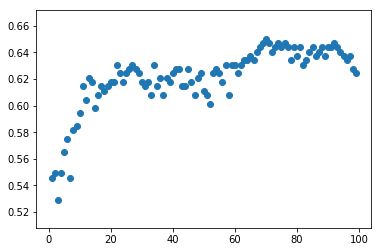

In [151]:

#K = 1

#model = 'progan' #Val set from same model(s)

def knn_classify(ref_feats, x_feats, votes_by_index, k_num):
    dists = np.linalg.norm(x_feats - ref_feats, axis=1)
    
    kNN = sorted(enumerate(dists), key = lambda x: x[1])[:k_num]
    kNN_votes = reduce(lambda x, y: [x[0] + y[0], x[1] + y[1]], 
                       [votes_by_index[z[0]] for z in kNN])
    
    fake_votes, real_votes = kNN_votes
    return real_votes >= fake_votes # Tie break by guessing "fake"


def knn_eval(model, k_num):
    correct_guesses = 0
    incorrect_guesses = 0

    for x in val_files[model]:
        feats = features_by_file[model][x]

        model_votes_by_index = [votes[model][f] for f in train_files[model]]
        pred = knn_classify(train_feats[model], feats, model_votes_by_index, k_num) #True is "real", False is "fake"

        val_fake_votes, val_real_votes = votes[model][x]

        if pred:
            correct_guesses += val_real_votes
            incorrect_guesses += val_fake_votes
        else:
            correct_guesses += val_fake_votes
            incorrect_guesses += val_real_votes

    return(correct_guesses, incorrect_guesses)
    

def crossval_knn(model):
    rates = []
    for k in tqdm_notebook(range(1,100)):
        corrects, incorrects = knn_eval(model, k)
        rates.append(corrects/(corrects+incorrects))
    plt.scatter(range(1,100), rates)
    return np.argmax(rates) + 1, np.max(rates)

progan_best_k, progan_accuracy = crossval_knn('progan')
print(progan_best_k, progan_accuracy)


77 0.6783505154639176


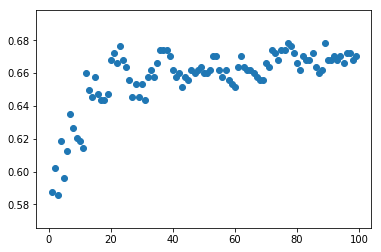

In [154]:
stylegan_best_k, stylegan_accuracy = crossval_knn('stylegan')
print(stylegan_best_k, stylegan_accuracy)


5 0.9556451612903226


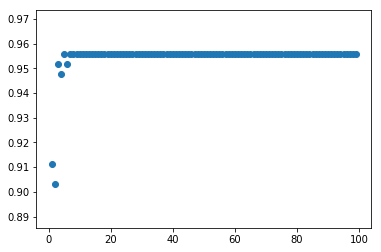

In [155]:
began_best_k, began_accuracy = crossval_knn('began')
print(began_best_k, began_accuracy)


3 0.9823008849557522


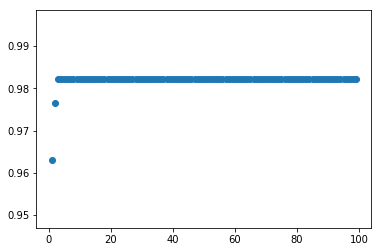

In [156]:
wgan_best_k, wgan_accuracy = crossval_knn('wgan')
print(wgan_best_k, wgan_accuracy)

In [75]:
for x in islice(began_val_files,50):
    #print(x)
    feats = began_features_by_file[x]
    dists = np.linalg.norm(feats - began_train_feats, axis=1)
    nn_index = np.argmin(dists)
    nn = began_train_files[nn_index]
    #print(began_votes[nn])
    

In [94]:
kNN = sorted(enumerate(dists), key = lambda x: x[1])[:5]
print(kNN)

reduce(lambda x, y: [x[0] + y[0], x[1] + y[1]], [progan_votes[progan_train_files[x[0]]] for x in kNN])

[(1309, 0.36460143), (373, 0.40736032), (831, 0.47139472), (1171, 0.49929243), (828, 0.5257756)]


[4, 2]

In [85]:
np.argmin(dists)

1309

Todo:
Functionize everything, include crossval+test
Run numbers on dense labels
#Abstract out dataset
Run on every combo of dataset